In [1]:
# Imports

import numpy as np
import pandas as pd
import tensorly as tl
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib
import scipy.io
import tlviz

from copy import deepcopy

import matcouply
from matcouply.decomposition import cmf_aoadmm
from matcouply.penalties import NonNegativity, Parafac2

import my_factor_tools
from my_factor_tools import *

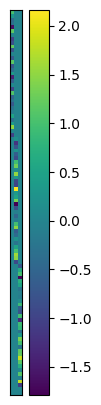

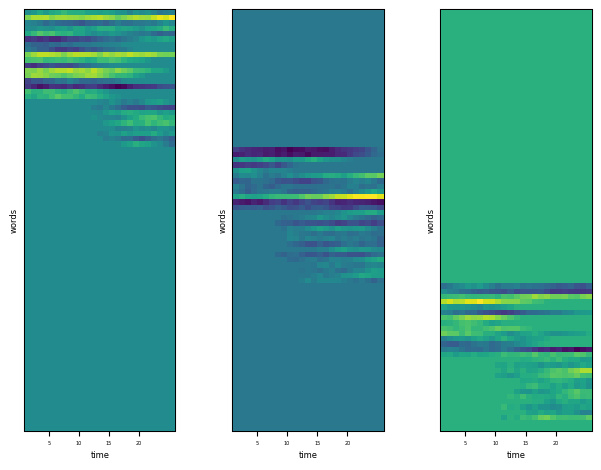

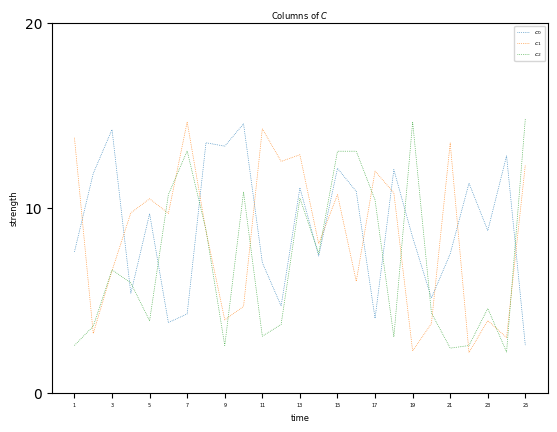

In [2]:
# Generate a synthetic dataset

d1 = np.random.randint(low=5,high=11) # choose when each concept shart shifting
d2 = np.random.randint(low=5,high=11)
d3 = np.random.randint(low=5,high=11)

my_generator = my_factor_tools.data_generator(
    no_of_concepts=3,               # Number of structures existing in the data i.e. the rank.
    I=100,
    J=80,
    K=25,                           # Tensor dimensions, where K denotes the no of timeslices.
    B_internal_overlap=30,          # Percentage that describes the overlap between the initial and final concepts in Bs.
    evolution_prob=0.3,             # probabilty of a point 'evolving' in a timeslice (only applicable in incremental drift).
    drift_indices=[[d1],[d2],[d3]],             # The indices that denote when concept changes in structure.
)

data = my_generator.generate_data()

my_generator.plot_As()
my_generator.plot_Bs()
my_generator.plot_Cs()

In [3]:
# Add noise to the data

eta = 0.75

noise = np.random.normal(0, 1, data.shape)

data = data + tl.norm(data) * eta * noise / tl.norm(noise)

In [4]:
# Create a randomly missing mask of selected percentage
# NOTE: This might take longer for higher percentages!

mask = my_factor_tools.get_random_mask(data,perc=50) # random mask
# mask = my_factor_tools.get_fiber_mask(data,mode=0,perc=50) # fibers missing
# mask = my_factor_tools.get_mixed_mask(data,perc=50) # mode-2 fibers + random

masked_data = data * mask # set the entries as missing

print(f'{100*np.sum(np.isnan(masked_data))/np.prod(masked_data.shape):.2f} % of input is missing.')

50.00 % of input is missing.


In [5]:
# Run 30 initializations of tPARAFAC2

D_gnd = my_generator.get_C_matrix()
B_gnd = my_generator.Bs
A_gnd = my_generator.As

factors_list = []
diagnostics_list = []

for init_no in tqdm.tqdm(range(20)):
    
    # input_data = deepcopy(masked_data)
    input_data = deepcopy(data)
    
    (weights, (D, B, A)), diagnostics = cmf_aoadmm(
        matrices=input_data.T, # Has to be .T because of tensorly
        rank=3, # No of components
        regs=[
            [NonNegativity()], # Mode-3 constraints
            [Parafac2(),myTemporalSmoothnessPenalty(smoothness_l=100)], # Mode-2 constraints
            [], # Mode-1 constraints
        ],
        l2_penalty=[10, 0, 10], # Ridge penalties for each mode [mode-3,mode-2,mode-1]
        return_errors=True,
        n_iter_max=8000,
        inner_n_iter_max=5, # inner admm iters
        tol=1e-8,
        absolute_tol=1e-10,
        feasibility_tol=1e-5,
        inner_tol=1e-5,
        em=True, # em = True: use EM updates, em = False: use RW updates
        verbose=0, # print intermediate run info every 500 iters
        random_state=init_no # if you would like to fix the initiliaizations
    )
    
    # If the run did not max_iters and it is not degenerate, store it
    if diagnostics.n_iter < 8000 and my_factor_tools.check_degenerate((D,B,A),threshold=-0.85) == False: 
        
        factors_list.append((D,B,A))
        diagnostics_list.append(diagnostics)
            
        print(f'Init {init_no}: fms with ground truth:{my_factor_tools.get_all_fms((D,B,A),(D_gnd,B_gnd,A_gnd))["full"]:.4f},f_val:{diagnostics.regularized_loss[-1]}')
        
    else:
        print(f'Init {init_no}: max_iters:{diagnostics.n_iter < 8000} - degenerate:{my_factor_tools.check_degenerate((D,B,A))}')

  0%|          | 0/20 [00:00<?, ?it/s]

Init 0: fms with ground truth:0.9838,f_val:296620.70992222027
Init 1: fms with ground truth:0.9838,f_val:296620.6888904405
Init 2: fms with ground truth:0.9838,f_val:296620.66918825445
Init 3: fms with ground truth:0.9838,f_val:296620.6928878441
Init 4: fms with ground truth:0.9838,f_val:296620.6782522376
Init 5: fms with ground truth:0.9838,f_val:296620.6716956271
Init 6: fms with ground truth:0.9838,f_val:296620.68157055636
Init 7: fms with ground truth:0.9838,f_val:296620.6407066933
Init 8: fms with ground truth:0.9838,f_val:296620.6576340108
Init 9: fms with ground truth:0.9838,f_val:296620.6878943838
Init 10: fms with ground truth:0.9838,f_val:296620.78700886207
Init 11: fms with ground truth:0.9838,f_val:296620.7720637141
Init 12: fms with ground truth:0.9838,f_val:296620.77229593653
Init 13: fms with ground truth:0.9838,f_val:296620.65547109867
Init 14: fms with ground truth:0.9838,f_val:296620.70989581593
Init 15: fms with ground truth:0.9838,f_val:296620.79424936406
Init 16: f

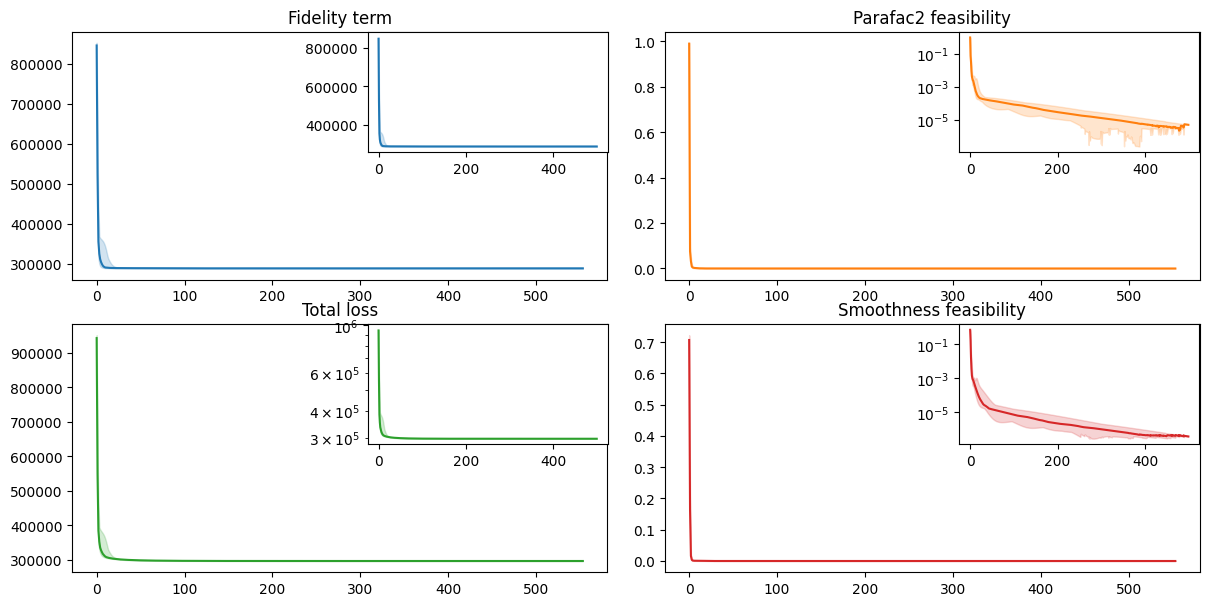

In [6]:
# Plot convergence diagnostics

my_factor_tools.plot_convergence(diagnostics_list,factors_list,zoom_in_to_first_n=500)

In [7]:
# Select best run

best_factors = factors_list[0]
best_error = diagnostics_list[0].regularized_loss[-1]

for init_no in range(1,len(best_factors)):
    if diagnostics_list[init_no].regularized_loss[-1] < best_error:
        best_factors = factors_list[init_no]
        best_errors = diagnostics_list[init_no].regularized_loss[-1]

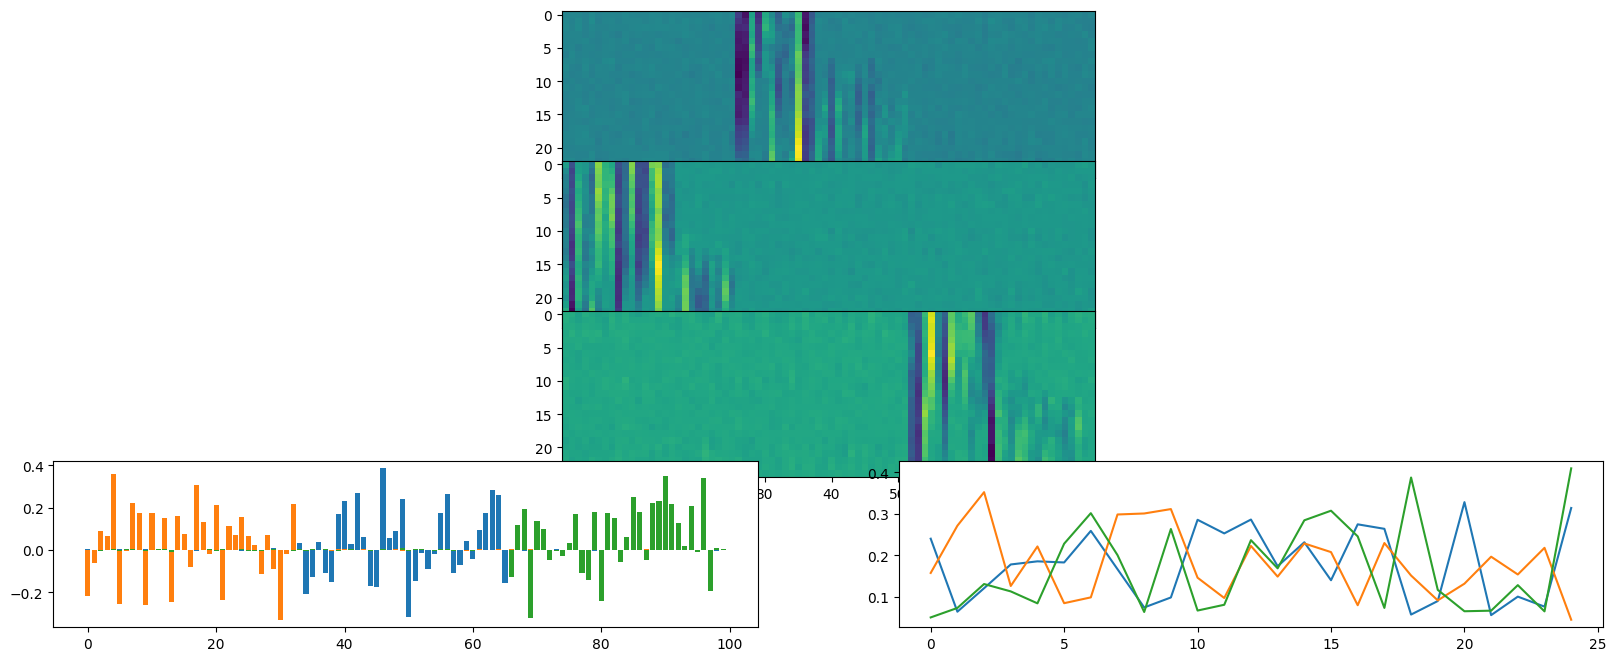

In [8]:
# Plot factors (after normalization)
    
my_factor_tools.plot_factors(best_factors)